In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import optimize as opt
from scipy.integrate import solve_ivp

In [2]:
def Kder_complex(z,Delta,Omega,K,F): #Returns zdot
    return ((K*z +F) - (z**2)*np.conj(K*z+F))/2 - (Delta + Omega*1j)*z

def Kder_vector(z,Delta,Omega,K,F): #z is treated as a 2D vector in R^2
    x = z[0]
    y = z[1]
    zdot = Kder_complex(x+y*1j,Delta,Omega,K,F)
    xdot = np.real(zdot)
    ydot = np.imag(zdot)
    return [xdot,ydot]

In [3]:
Delta0 = 3.8e-3
Omega0 = 1.4*Delta0
K0 = 4.5*Delta0
F0 = 3.5*Delta0

In [4]:
def p(t,tau,lag): #pfinal = 0 WLOG
    pinit = - lag
    pfinal = 0
    if t < 0:
        return  pinit
    elif t<tau:
        return pinit + (pfinal - pinit)/tau*t
    else:
        return pfinal

def pdot(t,tau,lag):
    if t < 0:
        return  0
    elif t<tau:
        return lag/tau
    else:
        return 0

In [14]:
def wder(t,w,tau,lag,Delta,Omega,K,F):
    return np.exp(-1j*p(t,tau,lag))*Kder_complex(w*np.exp(1j*p(t,tau,lag)),Delta,Omega,K,F) - 1j*w*pdot(t,tau,lag)

def wder_vectorised(t,w,tau,lag,Delta,Omega,K,F):
    x = w[0]
    y = w[1]
    w_derivative = wder(x+1j*y,t,tau,lag,Delta,Omega,K,F)
    return [np.real(w_derivative),np.imag(w_derivative)]

In [15]:
def integrate_w(lag,tau,t_end,t_step,Delta = Delta0, Omega = Omega0, K=K0,F=F0 ): #t_start = 0 WLOG
    solstb = opt.fsolve(Kder_vector,[1,-1],(Delta,Omega,K,F))
    def recovery(t,w,tau,lag,Delta,Omega,K,F):
        x = w[0]
        y = w[1]
        return (x - solstb[0])**2 + (x - solstb[1])**2 - 0.0001
    recovery.terminal = True
    recovery.direction = -1 #only counts positive to negative crossing
    solution = solve_ivp(wder_vectorised,(0,t_end),solstb,t_eval = np.linspace(0,t_end,int(t_end/t_step)),args= (tau,lag,Delta,Omega,K,F))
    return solution

In [16]:
myrangex = np.linspace(-1,1,40)
myrangey = np.linspace(-1,1,40)
x,y = np.meshgrid(myrangex,myrangey)
z = x + 1j*y
zdot = Kder_complex(z,Delta = Delta0,Omega = Omega0,K = K0,F = F0)#Put correct values here
u = np.real(zdot)/np.abs(zdot)
v = np.imag(zdot)/np.abs(zdot)

In [17]:
solstb = opt.fsolve(Kder_vector,[1,-1],(Delta0,Omega0,K0,F0))
solunstb = opt.fsolve(Kder_vector,[0,0],(Delta0,Omega0,K0,F0))
solsad = opt.fsolve(Kder_vector,[-1,0],(Delta0,Omega0,K0,F0))

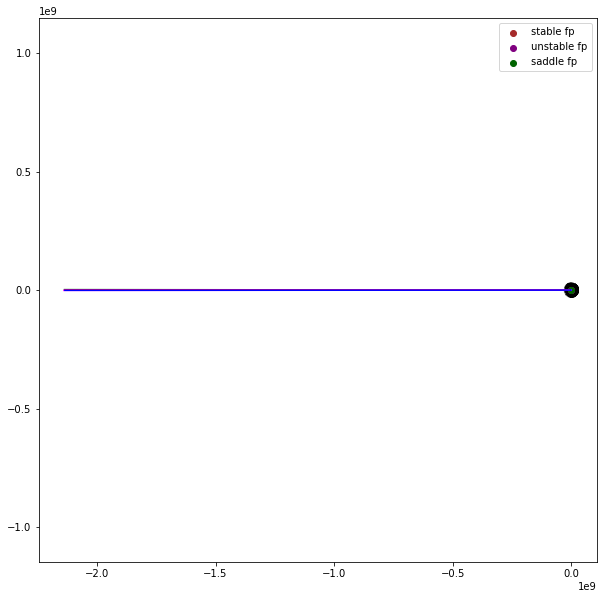

In [20]:
plt.quiver(x,y,u,v)
plt.scatter(solstb[0],solstb[1],label='stable fp',c = 'brown')
plt.scatter(solunstb[0],solunstb[1],label='unstable fp',c='purple')
plt.scatter(solsad[0],solsad[1],label='saddle fp',c='darkgreen')
lags = [8,9,12,-9]
colours = ['green','red','magenta','blue']
for index in range(4):
    lagval = lags[index]
    s = integrate_w(lagval,lagval,1000,1)
    plt.plot(s.y[0],s.y[1],c=colours[index])
    #solimported = get_linear_travel_IC(lagval,lagval,Delta0,Omega0,K0,F0)
plt.axis('equal')
plt.gcf().set_size_inches(10,10)
plt.legend()
plt.show()